In [1]:
import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import urllib.request

from keras.callbacks import ModelCheckpoint
from keras.datasets import mnist
from keras.layers import Conv2D,Dense,Dropout,Flatten,Input,MaxPooling2D,Reshape,UpSampling2D
from keras.models import Model
from keras.regularizers import l2

/home/gringet/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [24]:
# Constants
NB_INSTANCES = 5000
IMG_ROWS, IMG_COLS = 28, 28
INPUT_SHAPE = (IMG_ROWS,IMG_COLS,1)
BATCH_SIZE = 400
EPOCHS = 10
DATA_PATH = 'data/quickdraw/'
DATA_CLASSES = ['bat.npy','bird.npy','cake.npy','house.npy','monkey.npy','pizza.npy','saxophone.npy']
CHECKPOINTS_PATH = 'checkpoints/'
CHECKPOINTS_NAME = 'cae_model_adam_mae_10.hdf5'

In [3]:
# Functions definition
def load_quickdraw(data_path, data_classes, nb_instances):
    '''
        load quickdraw dataset from url
        ARGS:
            data_path: path in file system of data folder
            data_classes: names in file system of data files
            nb_instances: number of instances to retreive from each classe
        RETURNS:
            images_return: numpy array size nb_instance*nb_classesX28X28X1
            labels_return: numpy array size nb_instance*nb_classes of 0 to (nb_classes - 1) labels, depending on load order
    '''
    data_url = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/'
    
    if not os.path.isdir(data_path):
        os.makedirs(data_path) 
    for i in range(len(data_classes)):
        if not os.path.isfile(data_path + data_classes[i]):
            urllib.request.urlretrieve(data_url + data_classes[i], data_path + data_classes[i])
            
    images_return = np.load(data_path + data_classes[0])[np.random.permutation(nb_instances)]
    labels_return = np.zeros(images_return.shape[0])
    for i in range(1, len(data_classes)):
        images_return = np.concatenate((images_return, np.load(data_path + data_classes[i])[np.random.permutation(nb_instances)]))
        labels_return = np.concatenate((labels_return, np.ones(images_return.shape[0] - labels_return.shape[0]) * i))
    return images_return.astype('float32') / 255, labels_return

def load_mnist():
    (images_train, labels_train) , (images_test,labels_test) = mnist.load_data()
    images_train = (images_train.astype('float32') / 255.).reshape((len(images_train),28, 28, 1))
    images_test = (images_test.astype('float32') / 255.).reshape((len(images_test),28, 28, 1))
    return images_train, labels_train, images_test, labels_test

def use_checkpoints(path, file_name):
    if not os.path.isdir(path):
        os.makedir(path)
    return ModelCheckpoint(path + file_name, monitor='loss', verbose=1, save_best_only=True, mode='auto')

In [9]:
# Load dataset
images_train, labels_train, images_test, labels_test = load_mnist()

In [25]:
# Create the model
# images_train, labels_train = load_quickdraw(DATA_PATH, DATA_CLASSES, NB_INSTANCES)
input_img = Input(shape=INPUT_SHAPE)

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)

# x = Dropout(0.5)(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Flatten()(x)

encoded = Dense(2, activation='linear')(x)

x = Dense(392, activation='relu')(encoded)
x = Reshape((7,7,8))(x)

x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)

# x = Dropout(0.5)(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)

decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

encoder = Model(input_img, encoded)
autoencoder = Model(input_img, decoded)

# autoencoder.load_weights(CHECKPOINTS_PATH + 'cae_model_adam_mse_30.hdf5')
autoencoder.compile(optimizer='adam', loss='mean_absolute_error', metrics=['accuracy'])

In [81]:
# Show the summary of the model
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_85 (Conv2D)           (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_86 (Conv2D)           (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 7, 7, 8)           0         
_________________________________________________________________
flatten_17 (Flatten)         (None, 392)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 2)                 786       
__________

In [ ]:
# Train the model
autoencoder.fit(images_train,
                images_train,
                epochs=EPOCHS,
                batch_size=BATCH_SIZE,
                shuffle=True,
                verbose = 1,
                validation_split=0.33,
                callbacks=[use_checkpoints(CHECKPOINTS_PATH, CHECKPOINTS_NAME)]
               )

Train on 40199 samples, validate on 19801 samples
Epoch 1/10
40199/40199 [==============================] - 467s 12ms/step - loss: 0.1950 - acc: 0.8049 - val_loss: 0.1294 - val_acc: 0.8096

Epoch 00001: loss improved from inf to 0.19495, saving model to checkpoints/cae_model_adam_mae_10.hdf5
Epoch 2/10
16400/40199 [===========>..................] - ETA: 3:52 - loss: 0.1318 - acc: 0.8079

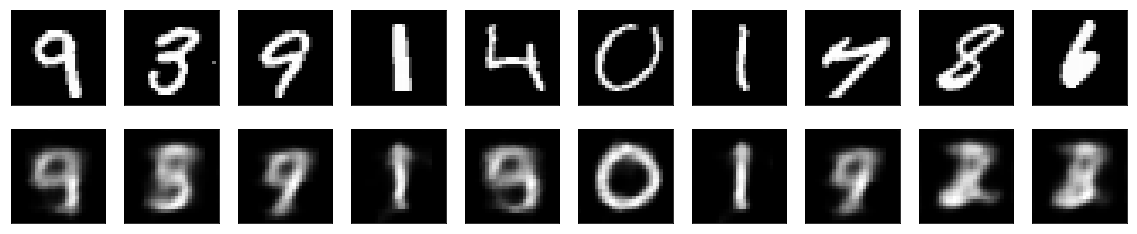

In [22]:
# Show some results of autoencoded images
N = 10

images_plot = images_train[np.random.randint(0,NB_INSTANCES-1,N)]
autoencoded_imgs = autoencoder.predict(images_plot)
plt.figure(figsize=(20, 4))
for i in range(N):
    # display original
    ax = plt.subplot(2, N, i + 1)
    plt.imshow(images_plot[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, N, i + 1 + N)
    plt.imshow(autoencoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

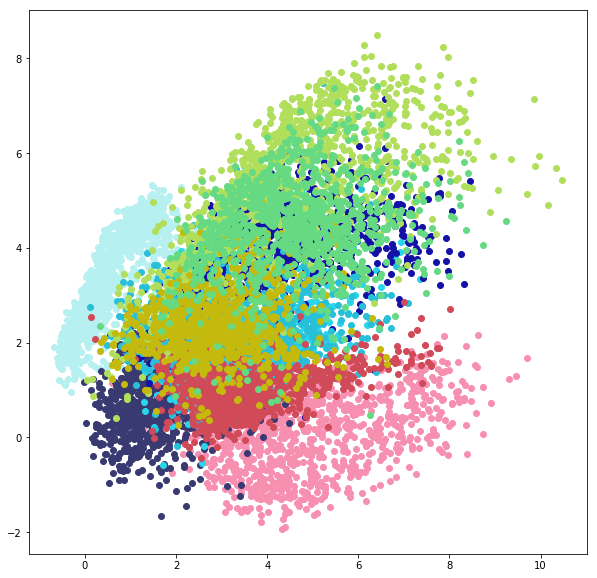

In [23]:
# Show the dataset in the 2d space
encoded_imgs = encoder.predict(images_test)
x = encoded_imgs[:,0]
y = encoded_imgs[:,1]

colors = np.random.rand(10,3)
plt.figure(figsize=(10, 10))

for i in range(10):
    plt.plot(x[labels_test == i], y[labels_test == i], 'o', color=colors[i]);
plt.show()